In [1]:
import pandas as pd
import geopandas as gpd
from shapely import wkt

import matplotlib.pyplot as plt
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
import matplotlib.animation as animation
from IPython.display import HTML
#https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html
import contextily as ctx

%matplotlib inline

In [2]:
df = pd.read_csv('sample_histogram_parks2buildings_distance_Tokyo.csv',sep=",")
gdf = gpd.GeoDataFrame(df, geometry=df['geometry'].apply(wkt.loads))
gdf.head()

,geohash,count_buildings,distance_park,geometry
0,xn76htc7t01vcm742q01,2,1290.0,"POLYGON ((139.775 35.535, 139.775 35.545, 139...."
1,xn76kc88n06qddh3jd96,2,1530.0,"POLYGON ((139.785 35.5549999999999, 139.785 35..."
2,xn76tdtg61hkpvf1dtvt,1,1530.0,"POLYGON ((139.825 35.605, 139.825 35.615, 139...."
3,xn76sbzcp0fzggmy6gdm,1,1230.0,"POLYGON ((139.795 35.595, 139.795 35.605000000..."
4,xn769k7mwc60x0pjn21n,3,630.0,"POLYGON ((139.635 35.615, 139.635 35.625, 139...."


## Plot WGS84

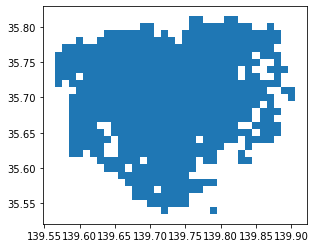

In [3]:
gdf[gdf.distance_park==0].plot()

## Calculate projected geometries

In [4]:
gdf.crs = {'init': 'epsg:4326'}
gdf_proj = gdf.to_crs(epsg=3857)
gdf_proj.head()

,geohash,count_buildings,distance_park,geometry
0,xn76htc7t01vcm742q01,2,1290.0,"POLYGON ((15559681.82562981 4236825.291064847,..."
1,xn76kc88n06qddh3jd96,2,1530.0,"POLYGON ((15560795.02053775 4239561.55937193, ..."
2,xn76tdtg61hkpvf1dtvt,1,1530.0,"POLYGON ((15565247.80016947 4246405.218702056,..."
3,xn76sbzcp0fzggmy6gdm,1,1230.0,"POLYGON ((15561908.21544568 4245036.144948686,..."
4,xn769k7mwc60x0pjn21n,3,630.0,"POLYGON ((15544097.09691875 4247774.463567947,..."


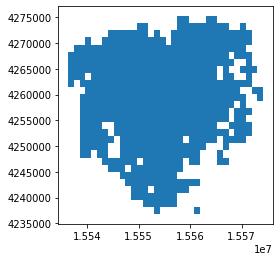

In [5]:
gdf_proj[gdf_proj.distance_park==0].plot()

## Plot projected
https://geopandas.readthedocs.io/en/latest/gallery/plotting_basemap_background.html

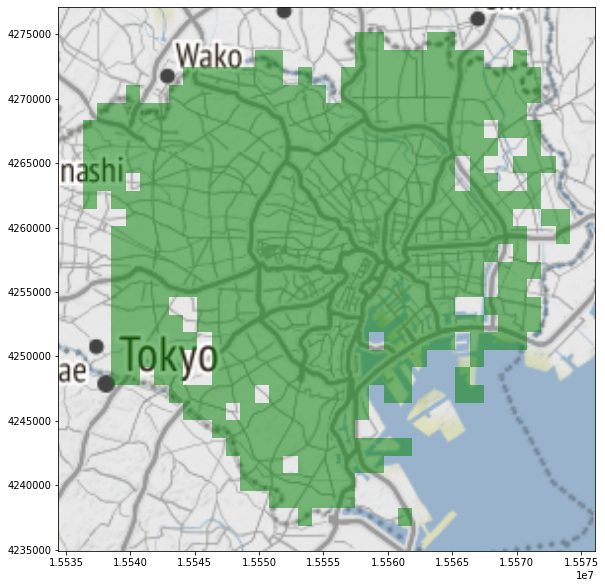

In [6]:
def add_basemap(ax, zoom, url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png'):
    xmin, xmax, ymin, ymax = ax.axis()
    basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=zoom, url=url)
    ax.imshow(basemap, extent=extent, interpolation='bilinear')
    # restore original x/y limits
    ax.axis((xmin, xmax, ymin, ymax))

ax = gdf_proj[gdf_proj.distance_park==0].plot(figsize=(10, 10), alpha=.5, color='green')
add_basemap(ax, zoom=10)

## Aggregate distances

In [7]:
gdf_proj_total = gdf_proj.groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})

distance = 60
gdf_proj_distance = gdf_proj[gdf_proj.distance_park<=distance]\
    .groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})
gdf_proj_distance['count_buildings_total'] = gdf_proj_total[['count_buildings']]
gdf_proj_distance['ratio'] = gdf_proj_distance.count_buildings/gdf_proj_distance.count_buildings_total
gdf_proj_distance.head()

,count_buildings,geometry,count_buildings_total,ratio
geohash,,,,
xn75pyxu0dwgxrwwnwfs,34,"POLYGON ((15537417.92747116 4261476.342026039,...",82,0.414634
xn75rbry2dybp6n9w94s,13,"POLYGON ((15537417.92747116 4262847.474715819,...",50,0.260000
xn75rfrb8dyurkqsye6t,44,"POLYGON ((15537417.92747116 4264218.779534912,...",244,0.180328
xn75rupfbenbxqy8ntdw,137,"POLYGON ((15537417.92747116 4265590.256568299,...",402,0.340796
xn75rvzv0envp3neqxfw,163,"POLYGON ((15537417.92747116 4266961.905900999,...",297,0.548822


## Plot animation

In [10]:
fig, ax = plt.subplots(figsize=(9,9))
plt.axis('off');

plt.suptitle('Animate distance from Tokyo buildings to nearest parks', fontsize=18)

xmin, ymin, xmax, ymax = gdf_proj.geometry.total_bounds
basemap, extent = ctx.bounds2img(xmin, ymin, xmax, ymax, zoom=10,
                                 url='http://tile.stamen.com/terrain/tileZ/tileX/tileY.png')
ax.imshow(basemap, extent=extent, interpolation='bilinear')
ax.axis((xmin, xmax, ymin, ymax))

ims = []
def updatefig(j):
    global ims, ax
    for im in ims:
        im.remove()
    # distances defined as 0m, 30m, 60m, ...
    distance = 30*j
    ax.set_title('%d meters or less' % (distance + 30), fontsize=18)
    
    gdf_proj_distance = gdf_proj[gdf_proj.distance_park<=distance]\
    .groupby(['geohash']).agg({'count_buildings':sum, 'geometry': 'first'})
    gdf_proj_distance['count_buildings_total'] = gdf_proj_total[['count_buildings']]
    gdf_proj_distance['ratio'] = gdf_proj_distance.count_buildings/gdf_proj_distance.count_buildings_total
    gdf_proj_distance['ratio'].head()

    geoms = gdf_proj_distance[gdf_proj_distance.ratio>=0.5].geometry
    ratio = gdf_proj_distance[gdf_proj_distance.ratio>=0.5].ratio
    patches = [PolygonPatch(geom) for geom in geoms]
    coll = PatchCollection(patches,color='green',alpha=0.5,edgecolor='None')
    im1 = ax.add_collection(coll)
    
    geoms = gdf_proj_distance[gdf_proj_distance.ratio<0.5].geometry
    ratio = gdf_proj_distance[gdf_proj_distance.ratio<0.5].ratio
    patches = [PolygonPatch(geom) for geom in geoms]
    coll = PatchCollection(patches,color='red',alpha=0.3,edgecolor='None')
    im2 = ax.add_collection(coll)
    
    ims = [im1,im2]
    return

anim = animation.FuncAnimation(fig, updatefig, frames=range(20), interval=500)
plt.close(anim._fig)
HTML(anim.to_html5_video())